In [87]:
#Importing the main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
#Taking note of the current versions used

print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


In [91]:
import json
import pandas as pd

def load_json(jfile):
    data = []
    with open(jfile) as f:
        for line in f.readlines():
            j = json.loads(line)
            url, headline, sarcastic = j['article_link'], j['headline'], j['is_sarcastic']
            data.append([url, headline, sarcastic])
    return pd.DataFrame(data, columns=['article_link', 'headline', 'is_sarcastic'])

In [92]:
json_1 = '/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json'
json_2 = '/content/drive/MyDrive/Sarcasm_Headlines_Dataset_v2.json'

In [93]:
#loading the dataset, from the json file stored in the given directory below, and visualising it
import os

data=load_json(json_2) # Working with version 2
data.head()

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


In [94]:
#Removing the link, and putting the organisation in its place
import re
data["organization"]=data["article_link"].apply(lambda x: re.findall(r"\w+",x)[2])
data=data.drop(["article_link"],axis=1)
data.head()

,headline,is_sarcastic,organization
0,thirtysomething scientists unveil doomsday clo...,1,theonion
1,dem rep. totally nails why congress is falling...,0,huffingtonpost
2,eat your veggies: 9 deliciously different recipes,0,huffingtonpost
3,inclement weather prevents liar from getting t...,1,theonion
4,mother comes pretty close to using word 'strea...,1,theonion


Now, this dataset needs preprocessing before feeding the suitable data to an LSTM. This includes : <br>
1. Getting the oraganisation of the artice, and save only that.
2. Remove all special characters from the sentences, to be left with plain text (wil be done automatically using tokenizer).

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      28619 non-null  object
 1   is_sarcastic  28619 non-null  int64 
 2   organization  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [96]:
data.describe() # balanced data or not

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


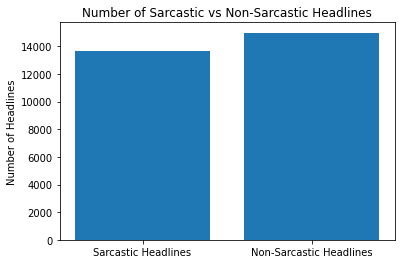

In [97]:
#The above statements can be visualised as
sarcastic=0
for i in range(len(data["is_sarcastic"])):
    if data["is_sarcastic"].iloc[i]==1:
        sarcastic+=1
normal=len(data["is_sarcastic"])-sarcastic
label_values={"Sarcastic Headlines" : sarcastic, "Non-Sarcastic Headlines" : normal}
plt.bar(label_values.keys(),label_values.values(),align="center")
plt.title("Number of Sarcastic vs Non-Sarcastic Headlines")
plt.ylabel("Number of Headlines")
plt.show()

In [99]:
#Dropping the "organization" column
data=data.drop(["organization"],axis=1) # since organization plays no role here
data.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


Preprocessing the data

In [100]:
!pip install Keras-preprocessing 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#Note that the training data/test data split will be done later

num_words=20000
max_sentence_len=400
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(data["headline"]))
X=tokenizer.texts_to_sequences(list(data["headline"]))
X=pad_sequences(X,maxlen=max_sentence_len)
Y=to_categorical(data["is_sarcastic"].values)
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))
print("The shape of the trainable data : {}".format(X.shape))
print("The shape of the labels for the data is : {}".format(Y.shape))

The number of unique words in the text corpus dictionary : 30884
The shape of the trainable data : (28619, 400)
The shape of the labels for the data is : (28619, 2)


In [102]:
embedding_words={}
file=open(r"/content/drive/MyDrive/glove (2).6B.300d.txt",'r', encoding="utf-8") ## using 300 glove embeddings
for line in file:
    #There are a number of lines containing embeddings for each word
    info=line.split(" ")
    #The first value in each line of the file is a unique word
    word=info[0]
    #The rest are embedding values of a specific dimension (to be displayed)
    embedding_values=np.array(info[1:],dtype="float32")
    #Storing these values
    embedding_words[word]=embedding_values
file.close()
print("The dimension/length of the embedding vector for each word is : {}"
     .format(len(embedding_words["go"])))

The dimension/length of the embedding vector for each word is : 300


Now, from these "embedding_words", the embedding matrix is obtained by running the cell below:

In [103]:
from keras.layers import Embedding
from keras.initializers import Constant

#The length/dimension of the embedding vector was found to be 300 after running the previous cell
embedding_dim=len(embedding_words["go"]) #or simply 300
#Initialising the embedding matrix
embedding_matrix=np.zeros((num_words,embedding_dim))
#Forming the embedding matrix by using the embedding vectors for only those words in the text corpus of the data  
for word,i in tokenizer.word_index.items():
    if i>num_words:
        continue
    embedding_vector=embedding_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [104]:
#Creating the embedding layer further with the help of keras
embeddings=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sentence_len,trainable=False)
print("The shape of the embedding matrix is {}".format(embedding_matrix.shape))

The shape of the embedding matrix is (20000, 300)


Buliding the model

In [105]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D 

model=Sequential()
model.add(embeddings)
model.add(Conv1D(32,3,activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(120,return_sequences=True)))
model.add(Flatten())
model.add(Dense(35,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [117]:
#Splittting the data into training and testing sets before fitting the model
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2) # 80-20 split

In [118]:
batch_size=70 #Using a batch size of 128, during gradient descent
num_epochs=15 #Number of iterations/epochs over the training set

history=model.fit(x_train,y_train,batch_size=batch_size,epochs=num_epochs,validation_data=(x_test,y_test))

Epoch 1/15
328/328 [==============================] - 9s 27ms/step - loss: 0.3184 - accuracy: 0.8668 - val_loss: 0.2563 - val_accuracy: 0.8983
Epoch 2/15
328/328 [==============================] - 9s 26ms/step - loss: 0.3049 - accuracy: 0.8723 - val_loss: 0.2626 - val_accuracy: 0.8962
Epoch 3/15
328/328 [==============================] - 8s 26ms/step - loss: 0.2916 - accuracy: 0.8798 - val_loss: 0.2664 - val_accuracy: 0.8880
Epoch 4/15
328/328 [==============================] - 9s 27ms/step - loss: 0.2871 - accuracy: 0.8835 - val_loss: 0.2665 - val_accuracy: 0.8910
Epoch 5/15
328/328 [==============================] - 8s 25ms/step - loss: 0.2734 - accuracy: 0.8888 - val_loss: 0.2637 - val_accuracy: 0.8899
Epoch 6/15
328/328 [==============================] - 8s 26ms/step - loss: 0.2691 - accuracy: 0.8902 - val_loss: 0.2737 - val_accuracy: 0.8814
Epoch 7/15
328/328 [==============================] - 8s 26ms/step - loss: 0.2585 - accuracy: 0.8909 - val_loss: 0.2816 - val_accuracy: 0.8816

The above model yeilds the following results:
1. The mean loss on the training set : 0.2288
2. The accuracy on the training set : 90.76%

In [119]:
test_performance=model.evaluate(x_test,y_test)
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))

179/179 [==============================] - 2s 9ms/step - loss: 0.2900 - accuracy: 0.8704
The loss of the model on the test set : 0.2899596393108368
The accuracy of the model on the test set : 87.03703880310059%


In [120]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 300)          6000000   
                                                                 
 conv1d (Conv1D)             (None, 398, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 32)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 199, 240)         146880    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 47760)             0

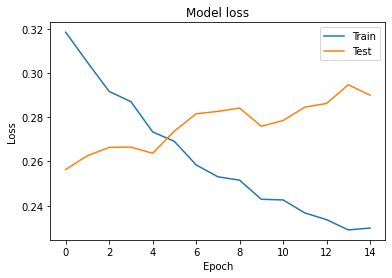

In [122]:
#Visualising the loss of the model, throughout the training process
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("modelloss_sarcasmdetection.jpg")

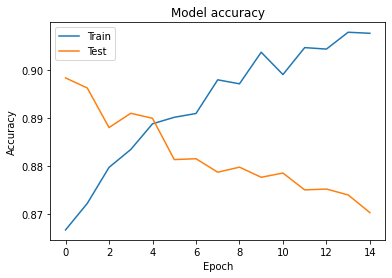

In [123]:
#Visualising the accuracy of the model, throughout the training process
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("modelacc_sarcasmdetection.jpg")

In [124]:
#Checking the validity of this model on some own made up headlines

my_headline1="Wow you are looking so beautiful" #Meant to be sarcastic
my_headline2="The facts imply that the suspect used a gun" #Meant to be non-sarcastic
my_headline3="It looks like Trump is very affectionate" #Meant to be sarcastic
my_headline4="The economy is on the brink of collapse" #Meant to be non-sarcastic

my_headline11=tokenizer.texts_to_sequences(my_headline1)
my_headline22=tokenizer.texts_to_sequences(my_headline2)
my_headline33=tokenizer.texts_to_sequences(my_headline3)
my_headline44=tokenizer.texts_to_sequences(my_headline4)

my_headline11=pad_sequences(my_headline11,maxlen=max_sentence_len,dtype="int32",value=0)
my_headline22=pad_sequences(my_headline22,maxlen=max_sentence_len,dtype="int32",value=0)
my_headline33=pad_sequences(my_headline33,maxlen=max_sentence_len,dtype="int32",value=0)
my_headline44=pad_sequences(my_headline44,maxlen=max_sentence_len,dtype="int32",value=0)

prediction1=model.predict(my_headline11,batch_size=1)[0]
prediction2=model.predict(my_headline22,batch_size=1)[0]
prediction3=model.predict(my_headline33,batch_size=1)[0]
prediction4=model.predict(my_headline44,batch_size=1)[0]

if np.argmax(prediction1)==1:
    print("The headline - " + my_headline1 + " : Not Sarcastic")
else:
    print("The headline - " + my_headline1 + " : Sarcastic")
    
if np.argmax(prediction2)==1:
    print("The headline - " + my_headline2 + " : Not Sarcastic")
else:
    print("The headline - " + my_headline2 + " : Sarcastic")

if np.argmax(prediction3)==1:
    print("The headline - " + my_headline3 + " : Not Sarcastic")
else:
    print("The headline - " + my_headline3 + " : Sarcastic")
    
if np.argmax(prediction4)==1:
    print("The headline - " + my_headline4 + " : Not Sarcastic")
else:
    print("The headline - " + my_headline4 + " : Sarcastic")

39/39 [==============================] - 0s 6ms/step
The headline - Wow you are looking so beautiful : Sarcastic
The headline - The facts imply that the suspect used a gun : Not Sarcastic
The headline - It looks like Trump is very affectionate : Sarcastic
The headline - The economy is on the brink of collapse : Not Sarcastic


In [125]:
print(prediction1)
print(prediction2)
print(prediction3)
print(prediction4)

[0.57177967 0.4273843 ]
[0.40286306 0.5969079 ]
[0.8106389  0.19044138]
[0.40286306 0.5969079 ]


The model is thus working decently well enough, with a good enough accuracy, similar on both the training and test set. <br>
The model is also decently able to identify sarcastic, and non-sarcastic headlines, written by a normal person as well.

Saving the current model for future usage

In [128]:

model_json = model.to_json()
with open("/content/drive/MyDrive/BiLSTM models/model_sarcasmdetection.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/BiLSTM models/BestVersion.hdf5")